In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import cudf

from tqdm import tqdm

tqdm.pandas()

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/scan-classification-challange/sample_submission.csv
/kaggle/input/scan-classification-challange/df_train.csv
/kaggle/input/scan-classification-challange/df_test.csv


In [2]:
#%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils

import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 577.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 17.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install -U pymorphy2-dicts-ru

Note: you may need to restart the kernel to use updated packages.


In [5]:
PATH = '/kaggle/input/scan-classification-challange/'

In [6]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [7]:
#посмотрим на трейн
train = pd.read_csv(PATH + 'df_train.csv')

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    60000 non-null  object
 1   class   60000 non-null  object
dtypes: object(2)
memory usage: 937.6+ KB


In [9]:
#посмотрим на количество классов
train['class'].nunique()

50

In [10]:
#посмотрим на сами классы и их распределение
train['class'].value_counts()

O                                                   40159
Теракт                                               1898
Взятки                                               1801
Экстремизм                                           1798
Уголовное обвинение                                  1634
Пожары                                               1510
Привлечение к уголовной ответственности              1475
Землетрясение                                         841
Утечка нефти                                          816
Противодействие коррупции                             707
Поддержка террористов                                 702
Заключение под стражу                                 694
Нарушение закона                                      636
Коррупция                                             599
Уголовное задержание                                  517
Наводнение                                            489
Кораблекрушение                                       378
Авиакатастрофа

<AxesSubplot:>

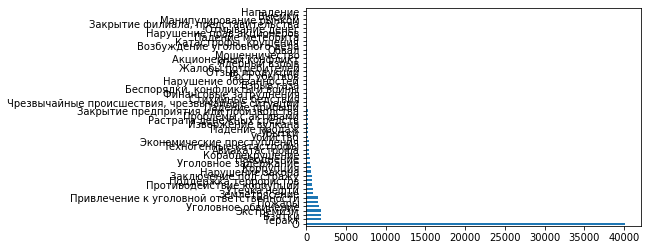

In [11]:
train['class'].value_counts().plot(kind = 'barh')

Распределение неравномерное. Доминирование класса "О". Мне кажется, что при автоматической разметке, этот класс присваивался текстам, которые не смогли определить к какому-нибудь классу. 
Эту неравномерность нужно будет учитывать при разделении на трейн и тест.

In [12]:
#посмотрим несколко примеров
train.sample(3)

,text,class
52730,За несколько часов до этого Государственный де...,O
18818,"Видимо это так сказалось на ее психике, что он...",O
30577,Мать Саакашвили заявила о сфабрикованности уго...,O


In [13]:
train['text'].iloc[44556]

'И этому есть весомые причины, ведь авиакатострофы хоть и случаются нечасто, зато о них пишут и говорят в разы больше, чем об автоавариях, железнодорожных и кораблекрушениях.'

In [14]:
train['class'].iloc[44556]

'Кораблекрушение'

Как видно из примера выше, разметка не совсем корректная. Но:
1. судя по всему тест размечен таким же образом, поэтому и корректировать классы будет не правильно;
2. количество размеченных новостей, почти 20 тысяч, поэтому перебирать их нецелесообразно с точки зрения затраченного времени. 

### Лемматизирую текст

In [15]:
import pymorphy2 

In [16]:
morph = pymorphy2.MorphAnalyzer()

In [17]:
def lem(x):
    x = list(x.split())
    x = [morph.parse(w)[0].normal_form for w in x]
    return x

In [18]:
#train_cuda = cudf.DataFrame(train)

In [19]:
train['text_lem'] = train['text'].progress_apply(lem)

100%|██████████| 60000/60000 [07:05<00:00, 140.89it/s]


In [20]:
train.sample(3)

,text,class,text_lem
12863,"Адвокат Данил Шицов, защищающий Половникова, с...",O,"[адвокат, данил, шицов,, защищать, половникова..."
20504,Об этом заявил представитель Следственного ком...,O,"[о, это, заявить, представитель, следственный,..."
26597,"В министерстве образования, как говорит Елена ...",O,"[в, министерство, образования,, как, говорить,..."


In [21]:
#%time
#train_cuda['text_lem'] = train['text'].apply(lem)

In [22]:
unique_words = {}
for i in tqdm(train.index):
    for j in set(train['text_lem'].loc[i]):
        if len(j) == 1:
            pass
        else:
            if j in unique_words.keys():
                unique_words[j] += 1
            else:
                unique_words[j] = 1

100%|██████████| 60000/60000 [00:01<00:00, 33839.38it/s]


In [23]:
#unique_words = {}
#for i in tqdm(train_cuda.index):
#    for j in set(train_cuda['text_lem'].loc[i]):
#        if j in unique_words.keys():
#            unique_words[j] += 1
#        else:
#            unique_words[j] = 1

In [24]:
sorted(list(unique_words.values()), reverse = True)[20000]

4

In [25]:
#train = pd.DataFrame(train_cuda)

In [26]:
pop_words = []
for i in tqdm(unique_words.keys()):
    if unique_words[i] < 4:
        pass
    else:
        pop_words.append(i)

100%|██████████| 109544/109544 [00:00<00:00, 1295178.92it/s]


In [27]:
pop_words

['вестись',
 'по',
 'уверен:',
 'другой',
 'без',
 'или',
 'лично',
 'то',
 'должный',
 'задача',
 'продолжать',
 'он',
 'обязать',
 'быть',
 'есть',
 'работа',
 'при',
 'этом,',
 'например,',
 'они',
 'служебный',
 'взгляды,',
 'допуск',
 'анкета',
 'гриф',
 'документ',
 'граница',
 'поездка',
 'хранить',
 '"длить',
 'сотрудник',
 'политический',
 'информация',
 'отмечать',
 'специальный',
 'отдел',
 'за',
 '1-й',
 'меры",',
 'это',
 'более',
 'он.',
 'необходимо',
 'сирийский',
 'активный',
 'но',
 'пока',
 'служба',
 'принимать',
 'безопасность',
 'отметить',
 'сообщили,',
 'днк',
 'найти',
 'тело',
 'что',
 'мужчина',
 'на',
 'совпасть',
 'мвд',
 'пресс-секретарь',
 'белый',
 'для',
 'псак',
 'брифинг',
 'среда',
 'сообщить',
 'дом',
 'журналистов.',
 'регулярный',
 'джена',
 'добавить',
 'обжаловать',
 'мы',
 'приговор",',
 'ул.',
 'верхнекамский',
 'г.',
 'кирс,',
 'милицейский',
 'произойти',
 'пожар',
 'автомобиле;',
 'район,',
 'новость',
 '(фото:',
 'альшевский',
 'кража',
 '

In [28]:
def text_lem_set(x):
    y = []
    for w in x:
        if w in pop_words:
            y.append(w)
        else:
            pass
    return y          
            

In [29]:
train['text_lem_set'] = train['text_lem'].progress_apply(lambda x: text_lem_set(x))

100%|██████████| 60000/60000 [02:24<00:00, 414.13it/s]


In [30]:
train.sample()

,text,class,text_lem,text_lem_set
16750,По словам регионального министра здравоохранен...,O,"[по, слово, региональный, министр, здравоохран...","[по, слово, региональный, министр, здравоохран..."


In [31]:
train['text_lem_set_len'] = train['text_lem_set'].apply(lambda x: len(x))

<AxesSubplot:>

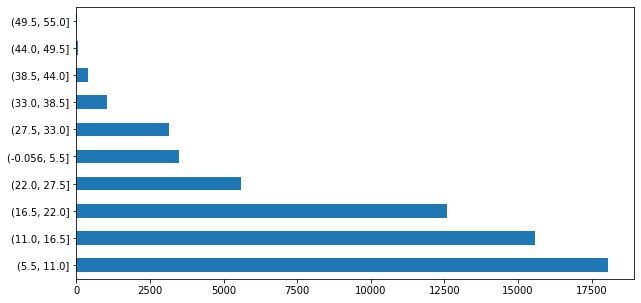

In [32]:
train['text_lem_set_len'].value_counts(bins = 10).plot(kind = 'barh',figsize = (10, 5))

In [33]:
len(pop_words)

20150

Количество уникальных слов 162 000 \
Лемматизированных уникальных слов 109 627

##  Попробую пойти по пути токенизации текста и моделей TesorFlow

In [34]:
# Максимальное количество слов 
num_words = len(pop_words)
# Максимальная длина новости
max_news_len = 29
# Количество классов новостей
nb_classes = 50

In [35]:
train['class'] = train['class'].astype('category')
train['class_cat'] = train['class'].cat.codes
train.sample(3)

,text,class,text_lem,text_lem_set,text_lem_set_len,class_cat
15096,"Он уже год не член фракции"", - посетовал Корни...",O,"[он, уже, год, не, член, фракции"",, -, посетов...","[он, уже, год, не, член, посетовать]",6,0
8784,"Президент Украины утверждает, что нынешний кие...",O,"[президент, украина, утверждает,, что, нынешни...","[президент, украина, утверждает,, что, нынешни...",12,0
51043,В ответ премьер-министр Израиля Биньямин Нетан...,O,"[в, ответ, премьер-министр, израиль, биньямин,...","[ответ, премьер-министр, израиль, биньямин, не...",16,0


In [36]:
X = train['text_lem_set']
y = train['class']

In [37]:
y = pd.get_dummies(y)

In [38]:
y.sample()

,O,Авиакатастрофа,Акционерный конфликт,"Беспорядки, конфликты и войны",Взрыв газа,Взятки,Возбуждение уголовного дела,Выемки,Жалобы потребителей,Заключение под стражу,...,Убийство,Убытки,Уголовное задержание,Уголовное обвинение,Утечка нефти,Финансовые затруднения,"Чрезвычайные происшествия, чрезвычайные ситуации",Экономические преступления,Экстремизм,Ядерный взрыв
9388,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
#разделяем на трейн и тест с учётом неравномернойти классов

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.2)

In [40]:
X_train

59770    [на, пальма, произойти, землетрясение,, сильны...
8547     [это, год, на, территория, сахалинский, област...
55964    [кроме, этого,, вчера, зафиксировать, восемь, ...
24538    [как, сообщить, "интерфакс",, проверка, не, быть]
44148    [он, сказать, корреспондент, "кавказский, узла...
                               ...                        
16703    [котельничский, район,, д., произойти, пожар, ...
26653    [американский, военный, вертолёт, потерпеть, к...
13345    [лидер, "нацкорпуса", андрей, отметил,, что, с...
11220    [февраль, 2004, год, военный, суд, кыргызстан,...
14238    [который, произойти, за, три, день, до, печаль...
Name: text_lem_set, Length: 48000, dtype: object

Преобразую номера классов в кагориальную матрицу 

In [41]:
y_train

,O,Авиакатастрофа,Акционерный конфликт,"Беспорядки, конфликты и войны",Взрыв газа,Взятки,Возбуждение уголовного дела,Выемки,Жалобы потребителей,Заключение под стражу,...,Убийство,Убытки,Уголовное задержание,Уголовное обвинение,Утечка нефти,Финансовые затруднения,"Чрезвычайные происшествия, чрезвычайные ситуации",Экономические преступления,Экстремизм,Ядерный взрыв
59770,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8547,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55964,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24538,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44148,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16703,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26653,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13345,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
y_train = np.array(y_train)

In [43]:
y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [44]:
y_test = np.array(y_test)

In [45]:
y_test

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [46]:
tokenizer = Tokenizer(num_words=num_words)

In [47]:
tokenizer.fit_on_texts(train['text_lem_set'])

In [48]:
train_sequences = tokenizer.texts_to_sequences(X_train)

x_train = pad_sequences(train_sequences, maxlen=max_news_len)

test_sequences = tokenizer.texts_to_sequences(X_test)

x_test = pad_sequences(test_sequences, maxlen=max_news_len)

## Сверточная нейронная сеть

In [49]:
model_cnn = Sequential()
model_cnn.add(Embedding(num_words, 32, input_length=max_news_len))
model_cnn.add(Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(50, activation='softmax'))

2022-06-26 09:53:51.429597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-26 09:53:51.434607: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-26 09:53:51.435752: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-26 09:53:51.437348: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [50]:
model_cnn.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [51]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 29, 32)            644800    
_________________________________________________________________
conv1d (Conv1D)              (None, 25, 250)           40250     
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32128     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                6450      
Total params: 723,628
Trainable params: 723,628
Non-trainable params: 0
_________________________________________________________________


In [52]:
model_cnn_save_path = './model_weights/best_model_cnn.h5'
checkpoint_callback_cnn = ModelCheckpoint(model_cnn_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [53]:
history_cnn = model_cnn.fit(x_train, 
                            y_train, 
                            epochs=5,
                            batch_size=128,
                            validation_split=0.01,
                            callbacks=[checkpoint_callback_cnn],
                            use_multiprocessing=True)

2022-06-26 09:53:58.756990: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-06-26 09:54:00.044266: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


372/372 [==============================] - 9s 6ms/step - loss: 1.3760 - accuracy: 0.7067 - val_loss: 0.9140 - val_accuracy: 0.7896

Epoch 00001: val_accuracy improved from -inf to 0.78958, saving model to ./model_weights/best_model_cnn.h5
Epoch 2/5
372/372 [==============================] - 2s 6ms/step - loss: 0.6323 - accuracy: 0.8360 - val_loss: 0.6005 - val_accuracy: 0.8417

Epoch 00002: val_accuracy improved from 0.78958 to 0.84167, saving model to ./model_weights/best_model_cnn.h5
Epoch 3/5
372/372 [==============================] - 2s 5ms/step - loss: 0.3965 - accuracy: 0.8926 - val_loss: 0.4745 - val_accuracy: 0.8854

Epoch 00003: val_accuracy improved from 0.84167 to 0.88542, saving model to ./model_weights/best_model_cnn.h5
Epoch 4/5
372/372 [==============================] - 2s 5ms/step - loss: 0.2562 - accuracy: 0.9248 - val_loss: 0.4477 - val_accuracy: 0.8833

Epoch 00004: val_accuracy did not improve from 0.88542
Epoch 5/5
372/372 [==============================] - 2s 5ms/

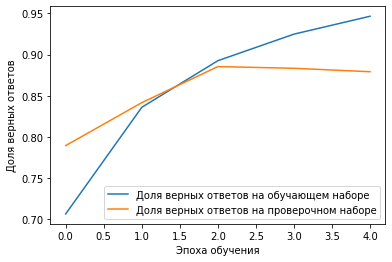

In [54]:
plt.plot(history_cnn.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Cеть LSTM

In [55]:
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 32, input_length=max_news_len))
model_lstm.add(LSTM(16))
model_lstm.add(Dense(50, activation='softmax'))

In [56]:
model_lstm.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [57]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 29, 32)            644800    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                3136      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                850       
Total params: 648,786
Trainable params: 648,786
Non-trainable params: 0
_________________________________________________________________


In [58]:
model_lstm_save_path = './model_weights/best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [59]:
history_lstm = model_lstm.fit(x_train, 
                              y_train, 
                              epochs=6,
                              batch_size=128,
                              validation_split=0.01,
                              callbacks=[checkpoint_callback_lstm],
                              use_multiprocessing=True)

Epoch 1/6
372/372 [==============================] - 5s 8ms/step - loss: 1.9375 - accuracy: 0.6607 - val_loss: 1.5571 - val_accuracy: 0.6292

Epoch 00001: val_accuracy improved from -inf to 0.62917, saving model to ./model_weights/best_model_lstm.h5
Epoch 2/6
372/372 [==============================] - 3s 7ms/step - loss: 1.2441 - accuracy: 0.6837 - val_loss: 1.2859 - val_accuracy: 0.6729

Epoch 00002: val_accuracy improved from 0.62917 to 0.67292, saving model to ./model_weights/best_model_lstm.h5
Epoch 3/6
372/372 [==============================] - 2s 7ms/step - loss: 0.9875 - accuracy: 0.7501 - val_loss: 1.0408 - val_accuracy: 0.7646

Epoch 00003: val_accuracy improved from 0.67292 to 0.76458, saving model to ./model_weights/best_model_lstm.h5
Epoch 4/6
372/372 [==============================] - 2s 7ms/step - loss: 0.7497 - accuracy: 0.8198 - val_loss: 0.8556 - val_accuracy: 0.8083

Epoch 00004: val_accuracy improved from 0.76458 to 0.80833, saving model to ./model_weights/best_model

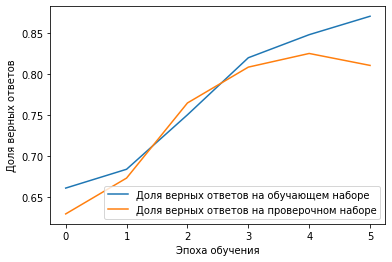

In [60]:
plt.plot(history_lstm.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Cеть GRU

In [61]:
model_gru = Sequential()
model_gru.add(Embedding(num_words, 32, input_length=max_news_len))
model_gru.add(GRU(16))
model_gru.add(Dense(50, activation='softmax'))

In [62]:
model_gru.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [63]:
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 29, 32)            644800    
_________________________________________________________________
gru (GRU)                    (None, 16)                2400      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                850       
Total params: 648,050
Trainable params: 648,050
Non-trainable params: 0
_________________________________________________________________


In [64]:
model_gru_save_path = './model_weights/best_model_gru.h5'
checkpoint_callback_gru = ModelCheckpoint(model_gru_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [65]:
history_gru = model_gru.fit(x_train, 
                              y_train, 
                              epochs=6,
                              batch_size=128,
                              validation_split=0.01,
                              callbacks=[checkpoint_callback_gru],
                              use_multiprocessing=True)

Epoch 1/6
372/372 [==============================] - 4s 7ms/step - loss: 1.8688 - accuracy: 0.6640 - val_loss: 1.5149 - val_accuracy: 0.6375

Epoch 00001: val_accuracy improved from -inf to 0.63750, saving model to ./model_weights/best_model_gru.h5
Epoch 2/6
372/372 [==============================] - 2s 6ms/step - loss: 1.2057 - accuracy: 0.7081 - val_loss: 1.1609 - val_accuracy: 0.7375

Epoch 00002: val_accuracy improved from 0.63750 to 0.73750, saving model to ./model_weights/best_model_gru.h5
Epoch 3/6
372/372 [==============================] - 2s 6ms/step - loss: 0.8911 - accuracy: 0.7985 - val_loss: 0.8794 - val_accuracy: 0.8021

Epoch 00003: val_accuracy improved from 0.73750 to 0.80208, saving model to ./model_weights/best_model_gru.h5
Epoch 4/6
372/372 [==============================] - 3s 7ms/step - loss: 0.6775 - accuracy: 0.8408 - val_loss: 0.7842 - val_accuracy: 0.8250

Epoch 00004: val_accuracy improved from 0.80208 to 0.82500, saving model to ./model_weights/best_model_gr

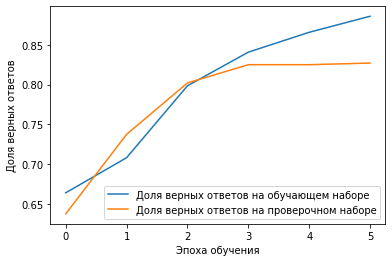

In [66]:
plt.plot(history_gru.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_gru.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Оцениваем качество работы сети на тестовом наборе данных

### Одномерная сверточная сеть 

In [67]:
model_cnn.load_weights(model_cnn_save_path)

In [68]:
model_cnn.evaluate(x_test, y_test, verbose=1)

375/375 [==============================] - 1s 3ms/step - loss: 0.4803 - accuracy: 0.8777


[0.4802940785884857, 0.8777499794960022]

### Сеть LSTM

In [69]:
model_lstm.load_weights(model_lstm_save_path)

In [70]:
model_lstm.evaluate(x_test, y_test, verbose=1)

375/375 [==============================] - 2s 4ms/step - loss: 0.7432 - accuracy: 0.8269


[0.7431889772415161, 0.8269166946411133]

### Сеть GRU

In [71]:
model_gru.load_weights(model_gru_save_path)

In [72]:
model_gru.evaluate(x_test, y_test, verbose=1)

375/375 [==============================] - 2s 4ms/step - loss: 0.5976 - accuracy: 0.8610


[0.5976331233978271, 0.8610000014305115]

# Загружу тестовые данные и получу предсказание

In [73]:
test = pd.read_csv(PATH + 'df_test.csv')
test.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [74]:
test.sample(3)

,text,class
25822,"Так, об этом написано даже в Википедии, в 2016...",O
9663,В е-декларации за 2020 год заммэра Владимир Во...,O
22261,"К талибам, по данным В.Я. Белокреницкого и Р.Р...",O


In [75]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   class   40000 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB


In [76]:
test['text_lem'] = test['text'].progress_apply(lem)

100%|██████████| 40000/40000 [04:45<00:00, 140.10it/s]


In [77]:
test['text_lem_set'] = test['text_lem'].progress_apply(lambda x: text_lem_set(x))

100%|██████████| 40000/40000 [01:39<00:00, 401.81it/s]


In [78]:
test_2_sequences = tokenizer.texts_to_sequences(test['text_lem_set'])

x_test_2 = pad_sequences(test_2_sequences, maxlen=max_news_len)

In [79]:
y_test_pred_cnn = model_cnn.predict(x_test_2, verbose=1)
#y_test_pred_lstm = model_lstm.predict(x_test_2, verbose=1)
y_test_pred_gru = model_gru.predict(x_test_2, verbose=1)

1250/1250 [==============================] - 2s 2ms/step


In [80]:
test_pred = np.zeros(y_test_pred_cnn.shape)
for i in tqdm(range(y_test_pred_cnn.shape[0])):
    for j in range(y_test_pred_cnn.shape[1]):
        test_pred[i,j] = max(y_test_pred_cnn[i,j], y_test_pred_gru[i,j])

test_pred.shape


100%|██████████| 40000/40000 [00:02<00:00, 16224.52it/s]


(40000, 50)

In [81]:
test_pred[1].max()

0.7931530475616455

In [82]:
test.sample(3)

,text,class,text_lem,text_lem_set
21856,"По версии следствия, утром 7 июля 2016 года об...",O,"[по, версия, следствия,, утром, 7, июль, 2016,...","[по, версия, следствия,, утром, июль, 2016, го..."
35746,Официальный представитель политического офиса ...,O,"[официальный, представитель, политический, офи...","[официальный, представитель, политический, офи..."
8327,Его обвинили в получении взятки в особо крупно...,O,"[он, обвинить, в, получение, взятка, в, особо,...","[он, обвинить, получение, взятка, особо, крупн..."


In [83]:
test_pred_class = []
for i in range(len(test_pred)):
    index, max_value = max(enumerate(test_pred[i]), key=lambda i_v: i_v[1])
    test_pred_class.append((index))

In [84]:
test_pred_class[0], len(test_pred_class)

(0, 40000)

In [85]:
test['class_cat'] = 0

In [86]:
y.columns[0]

'O'

In [87]:
for i in tqdm(test.index):
    test['class_cat'].iloc[i] = test_pred_class[i]

  0%|          | 0/40000 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
100%|██████████| 40000/40000 [00:11<00:00, 3360.79it/s]


In [88]:
test['class'] = test['class_cat'].apply(lambda x: y.columns[x])

In [89]:
test.sample(3)

,text,class,text_lem,text_lem_set,class_cat
869,Об этом сообщил телеканал 1TV со ссылкой на ис...,O,"[о, это, сообщить, телеканал, 1tv, с, ссылка, ...","[это, сообщить, телеканал, 1tv, ссылка, на, ис...",0
28051,"Это настоящий бич похоронной отрасли, – говори...",O,"[это, настоящий, бич, похоронный, отрасли,, –,...","[это, настоящий, похоронный, отрасли,, говорит...",0
4818,"Постпред РФ при ООН заявил, что ситуация в Афг...",O,"[постпред, рф, при, оон, заявил,, что, ситуаци...","[постпред, рф, при, оон, заявил,, что, ситуаци...",0


In [90]:
test['class'].value_counts()

O                                                   28171
Взятки                                               1423
Экстремизм                                           1396
Привлечение к уголовной ответственности              1237
Теракт                                               1193
Уголовное обвинение                                  1174
Пожары                                               1099
Землетрясение                                         661
Утечка нефти                                          588
Коррупция                                             350
Наводнение                                            346
Заключение под стражу                                 312
Противодействие коррупции                             280
Уголовное задержание                                  265
Поддержка террористов                                 256
Авиакатастрофа                                        219
Кораблекрушение                                       209
Техногенные ка

In [91]:
sub = pd.read_csv(PATH + 'sample_submission.csv')

In [92]:
sub.sample(5)

,id,class
4559,4559,O
37502,37502,O
7208,7208,O
31555,31555,O
1892,1892,O


In [93]:
submission = pd.DataFrame({'id':test.index})

In [94]:
submission['class'] = test['class']

In [95]:
submission.sample(3)

,id,class
9103,9103,O
10731,10731,O
37195,37195,Пожары


In [96]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      40000 non-null  int64 
 1   class   40000 non-null  object
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [97]:
#!pip install pandas==1.3.5

In [98]:
submission.to_csv('./submission.csv', index=False)